# NR PDSCH Throughput with HARQ
This notebook demonstrates how to measure the physical downlink shared channel (PDSCH) throughput of a 5G New Radio (NR) link, as specified in the 3GPP NR standard. It is similar to the MATLAB example [NR PDSCH Throughput](https://www.mathworks.com/help/5g/ug/nr-pdsch-throughput.html) and showcases the use of the following NeoRadium features:

- Carrier and Bandwidth Part classes.
- PDSCH and DMRS objects.
- LDPC and HARQ capabilities.
- CDL channel model and extraction of channel matrix and precoding matrix.
- Resource grids, populating them, and applying channel models to them.

In [2]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, LdpcEncoder, random, HarqEntity, SnrScheduler

In [3]:
# Create a Carrier object with 51 resource blocks and 30KHz subcarrier spacing
carrier = Carrier(numRbs=51, spacing=30)
carrier.print()
bwp = carrier.curBwp                      # The only bandwidth part in the carrier


Carrier Properties:
  Cell Id:              1
  Bandwidth Parts:      1
  Active BWP:           0
  Bandwidth Part 0:
    Resource Blocks:    51 RBs starting at 0 (612 subcarriers)
    Subcarrier Spacing: 30 kHz
    CP Type:            normal
    Bandwidth:          18.36 MHz
    symbolsPerSlot:     14
    slotsPerSubFrame:   2
    nFFT:               1024
    frameNo:            0
    slotNo:             0



In [4]:
# Initialize the modulation and code rate.
modulation = '16QAM'
codeRate = 490/1024

# Create a PDSCH onject with 2 tramsmission layers
pdsch = PDSCH(bwp, interleavingBundleSize=0, numLayers=2, nID=carrier.cellId)
pdsch.setDMRS(prgSize=0, configType=2, additionalPos=2, otherCdmGroups=[])
pdsch.print()

# Create an LDPC encoder object using base graph 1 and passing modulation and code rate settings
ldpcEncoder = LdpcEncoder(baseGraphNo=1,  modulation=modulation, txLayers=pdsch.numLayers, targetRate=codeRate)

# HARQ configuration:
harqType = "IR"                                     # "IR" -> "Incremental Redundancy", "CC" -> "Chase Combining"
numProc = 16                                        # Number of HARQ processes
harq = HarqEntity(ldpcEncoder, harqType, numProc)   # Create the HARQ entity
harq.print()

# Create the CDL channel model
channel = CdlChannel(bwp, 'C', delaySpread=300, carrierFreq=4e9, dopplerShift=5,
                     txAntenna = AntennaPanel([1,4], polarization="x"),                         # 8 TX antenna
                     rxAntenna = AntennaPanel([1,1], polarization="+", beamWidth=[75,360]),     # 2 RX antenna, Omni-directional
                     rxOrientation = [0,0,0])                                                   # Default is [180,0,0]
print(channel)


PDSCH Properties:
  mappingType: A
  nID: 1
  rnti: 1
  numLayers: 2
  numCodewords: 1
  modulation: 16QAM
  portSet: [0, 1]
  symSet:   0   1   2   3   4   5   6   7   8   9  10  11  12  13
  prbSet:   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
           20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
           40  41  42  43  44  45  46  47  48  49  50
  interleavingBundleSize: 0
  PRG Size: Wideband
  Bandwidth Part:
    Resource Blocks:    51 RBs starting at 0 (612 subcarriers)
    Subcarrier Spacing: 30 kHz
    CP Type:            normal
    Bandwidth:          18.36 MHz
    symbolsPerSlot:     14
    slotsPerSubFrame:   2
    nFFT:               1024
    frameNo:            0
    slotNo:             0
  DMRS:
    configType: 2
    nIDs: []
    scID: 0
    sameSeq: 1
    symbols: Single
    typeA1stPos: 2
    additionalPos: 2
    cdmGroups: [0, 0]
    deltaShifts: [0, 0]
    allCdmGroups: [0]
    symSet: [ 2  7 1

In [5]:
# Print header lines:
print("SNR(dB)  Tx Bits     Rx Bits     Throughput(%)  TX Blocks  RX Blocks  BLER(%)  Retry Mean  time(Sec.)")
print("-------  ----------  ----------  -------------  ---------  ---------  -------  ----------  ----------")

snrScheduler = SnrScheduler(6,1, loSnrVal=0, hiSnrVal=100)      # Start at 6 dB, use increments of 0.2 dB
numSlots = 1000                                                 # The number of slots transmitted for each SNR value
for snrDb in snrScheduler:
    random.setSeed(123)
    channel.restart()                                           # Reset the channel and the bandwidth part associated with it
    harq.reset()                                                # Reset HARQ state and buffers

    t0 = time.time()                                            # Start the timer
    for s in range(numSlots):                                   # The inner loop doing 'numSlot' transmissions
        grid = bwp.createGrid(pdsch.numLayers)                  # Create a resource grid with 2 layers
        pdsch.allocateResources(grid)                           # Allocat PDSCH resources including DMRS
        txBlockSizes = pdsch.getTxBlockSize(codeRate)           # Calculate the Transport Block Size (TBS)
        numBits = pdsch.getBitSizes(grid)                       # Total number of PDSCH data bits available in the resource grid

        # Preparing the transport blocks
        txBlocks = []                                           # Transport blocks, one per codeword.
        for c in range(harq.numCW):
            if harq.needNewData[c]:                             # New transmission.
                txBlocks += [ random.bits(txBlockSizes[c]) ]    # Create random bits for new transmissions
            else:                                               # Retransmission
                txBlocks += [ None ]                            # Set transport block to None to indicate a retransmission

        # The following function returns a coded, rate-matched bitstream, ready for transmission/retransmission
        rateMatchedCodeBlocks = harq.getRateMatchedCodeBlocks(txBlocks, numBits)    
        
        pdsch.populateGrid(grid, rateMatchedCodeBlocks)         # Map/modulate the data to the resource grid
        
        channelMatrix = channel.getChannelMatrix()              # Get channel matrix (Assuming perfect channel estimation)
        precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get precoding matrix based on the channel matrix
        
        precodedGrid = grid.precode(precoder)                   # Perform precoding
        
        rxGrid = precodedGrid.applyChannel(channelMatrix)       # Apply the channel to the precoded resource (Freq. domain)
        noisyRxGrid = rxGrid.addNoise(snrDb=snrDb, useRxPower=True) # Add noise (Using RX power to calcualte Noise Power)

        # Calculate the channel matrix with the precoding effect. This is assuming perfect channel estimation. For practical
        # channel estimation we can use the DMRS reference signals and use the "estimateChannelLS" method of resource grid object.
        precodingChannelMatrix = channelMatrix @ precoder[None,...]

        # Use the channel matrix (with precoding effect) to equalize the received resource grid
        eqGrid, llrScales = noisyRxGrid.equalize(precodingChannelMatrix)

        # Demodulate the equalized resource grid (eqGrid) to get the Log-Likelihood values
        llrs = pdsch.getLLRsFromGrid(eqGrid, pdsch.dataIndices, llrScales) 

        # Use HARQ entity to decode the LLRs to transport blocks
        decodedTxBlocks, blockErrors = harq.decodeLLRs(llrs, txBlockSizes, numIter=2)

        # Get the statistics from HARQ entity and print them:
        print("\r%-7d  %-10d  %-10d  %-13.2f  %-9d  %-9d  %-7.2f  %-10.2f  %-10.2f"
              %(snrDb, harq.totalTxBits, harq.totalRxBits, harq.throughput, harq.totalTxBlocks, 
                harq.totalRxBlocks, harq.bler, harq.meanTries, time.time()-t0), end='')
    
        channel.goNext()
        harq.goNext()
    
    snrScheduler.setData(harq.throughput)
    print("")

SNR(dB)  Tx Bits     Rx Bits     Throughput(%)  TX Blocks  RX Blocks  BLER(%)  Retry Mean  time(Sec.)
-------  ----------  ----------  -------------  ---------  ---------  -------  ----------  ----------
6        30216000    3263328     10.80          1000       108        89.20    3.54        158.70    
5        30216000    423024      1.40           1000       14         98.60    3.94        158.07    
4        30216000    0           0.00           1000       0          100.00   4.00        159.37    
3        30216000    0           0.00           1000       0          100.00   4.00        159.64    
7        30216000    5166936     17.10          1000       171        82.90    3.03        161.71    
8        30216000    6738168     22.30          1000       223        77.70    2.61        167.97    
9        30216000    8218752     27.20          1000       272        72.80    2.19        173.80    
10       30216000    10756896    35.60          1000       356        64.40    1.6

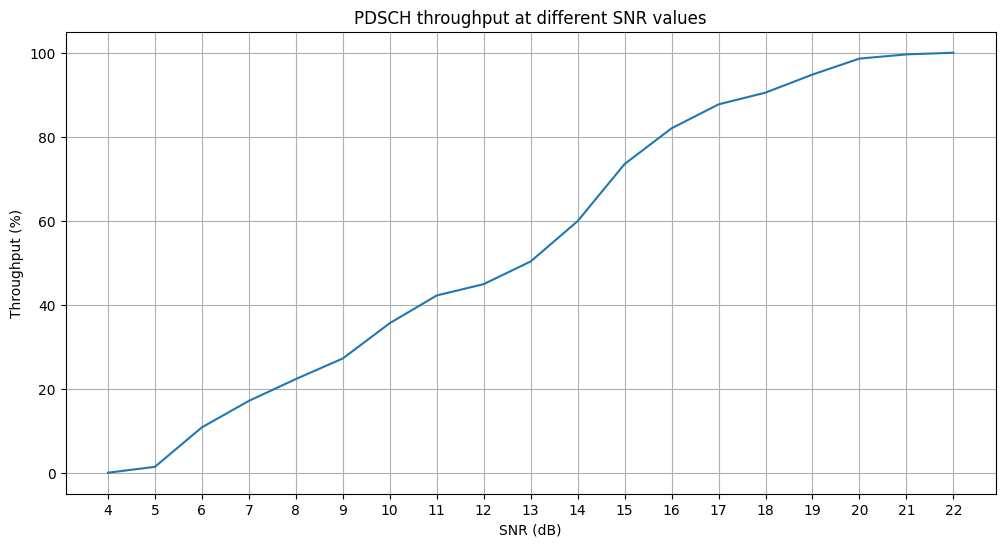

In [6]:
# Draw the throughput graph:
snrDbs, throughputs = snrScheduler.getSnrsAndData()
plt.figure(figsize=(12, 6))
plt.plot(snrDbs, throughputs)
plt.title("PDSCH throughput at different SNR values");
plt.grid()
plt.xlabel("SNR (dB)")
plt.xticks(snrDbs)
plt.ylabel("Throughput (%)")
plt.show()